# Correspondence of precursor emissions to ozone forcing

In AR6, we do not separate tropospheric and stratospheric ozone.

Coefficients provided by AerChemMIP models contributing to Thornhill et al. 2020, and historical time series from Skeie et al. 2020.

Once this is tuned, update FaIR (may need 1.6.2 release)

In [1]:
import fair
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from fair.constants import molwt
from fair.forcing.ozone_tr import stevenson
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from ar6.forcing.ozone import eesc

## The historcial forcing time series

Follow Skeie et al., 2020 exclusively for the historical (1850-2010)

Update 18.01.2020: 0.47 1750-2019 - the foot has come down

In [2]:
good_models = ['BCC-ESM1', 'CESM2(WACCM6)', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']
skeie_trop = pd.read_csv('../data_input/skeie_ozone_trop.csv', index_col=0)
skeie_trop = skeie_trop.loc[good_models]
skeie_trop.insert(0, 1850, 0)
skeie_trop.columns = pd.to_numeric(skeie_trop.columns)
skeie_trop.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
#skeie_trop.insert(0, 1750, -0.03)
#skeie_trop_post2010 = skeie_trop.loc['OsloCTM3',[2014,2017,2020]]-skeie_trop.loc['OsloCTM3', 2010]
#skeie_trop.loc[:,[2014,2017,2020]] = skeie_trop.loc[:,2010:2010].values + skeie_trop_post2010.values[None,:]
#skeie_trop = skeie_trop + 0.03

In [3]:
skeie_trop

,1850,1920,1930,1940,1950,1960,1970,1980,1990,2000,2007,2010,2014,2017,2020
Model,,,,,,,,,,,,,,,
BCC-ESM1,0.0,0.05020,0.06650,0.07970,0.1030,0.14860,0.2012,0.2367,0.2643,0.3086,0.3347,0.3404,NaN,NaN,NaN
CESM2(WACCM6),0.0,0.04420,0.05930,0.08410,0.1003,0.14520,0.1939,0.2350,0.2822,0.3318,0.3518,0.3711,NaN,NaN,NaN
GFDL-ESM4,0.0,0.05220,0.06250,0.08600,0.1096,0.16210,0.2113,0.2463,0.2733,0.3116,0.3280,0.3392,NaN,NaN,NaN
GISS-E2-1-H,0.0,0.04930,0.06740,0.07670,0.1137,0.14790,0.1850,0.2209,0.2684,0.3266,0.3593,0.3660,NaN,NaN,NaN
MRI-ESM2-0,0.0,0.05700,0.07230,0.08570,0.1096,0.15920,0.2159,0.2661,0.3122,0.3320,0.3397,0.3448,NaN,NaN,NaN
OsloCTM3,0.0,0.08204,0.09376,0.10548,0.1172,0.17065,0.2241,0.2777,0.3173,0.3527,0.3987,0.4047,0.4209,0.4117,0.4274


In [4]:
skeie_strat = pd.read_csv('../data_input/skeie_ozone_strat.csv', index_col=0)
skeie_strat = skeie_strat.loc[good_models]
skeie_strat.insert(0, 1850, 0)
skeie_strat.columns = pd.to_numeric(skeie_strat.columns)
skeie_strat.interpolate(axis=1, method='values', limit_area='inside', inplace=True)
skeie_strat

,1850,1920,1930,1940,1950,1960,1970,1980,1990,2000,2007,2010,2014,2017,2020
Model,,,,,,,,,,,,,,,
BCC-ESM1,0.0,0.00760,0.0092,0.01430,0.0239,0.03590,0.0496,0.0367,0.0085,0.0147,0.0189,0.0207,NaN,NaN,NaN
CESM2(WACCM6),0.0,0.02020,0.0221,0.04000,0.0346,0.04460,0.0533,0.0530,0.0282,0.0468,0.0456,0.0578,NaN,NaN,NaN
GFDL-ESM4,0.0,0.01380,0.0126,0.02260,0.0315,0.03600,0.0331,0.0145,-0.0397,-0.0209,-0.0206,-0.0170,NaN,NaN,NaN
GISS-E2-1-H,0.0,0.01820,0.0122,-0.00030,0.0248,0.02330,0.0321,0.0913,0.1171,0.0737,0.0776,0.0898,NaN,NaN,NaN
MRI-ESM2-0,0.0,0.00720,0.0144,0.01230,0.0198,0.03200,0.0570,0.0668,0.0618,0.0474,0.0403,0.0411,NaN,NaN,NaN
OsloCTM3,0.0,0.02485,0.0284,0.03195,0.0355,0.04535,0.0552,0.0710,0.0819,0.0876,0.1102,0.1198,0.1318,0.1294,0.1359


In [5]:
skeie_total = skeie_trop + skeie_strat
#skeie_total.drop([2014,2017,2020], inplace=True, axis=1)
skeie_total

,1850,1920,1930,1940,1950,1960,1970,1980,1990,2000,2007,2010,2014,2017,2020
Model,,,,,,,,,,,,,,,
BCC-ESM1,0.0,0.05780,0.07570,0.09400,0.1269,0.1845,0.2508,0.2734,0.2728,0.3233,0.3536,0.3611,NaN,NaN,NaN
CESM2(WACCM6),0.0,0.06440,0.08140,0.12410,0.1349,0.1898,0.2472,0.2880,0.3104,0.3786,0.3974,0.4289,NaN,NaN,NaN
GFDL-ESM4,0.0,0.06600,0.07510,0.10860,0.1411,0.1981,0.2444,0.2608,0.2336,0.2907,0.3074,0.3222,NaN,NaN,NaN
GISS-E2-1-H,0.0,0.06750,0.07960,0.07640,0.1385,0.1712,0.2171,0.3122,0.3855,0.4003,0.4369,0.4558,NaN,NaN,NaN
MRI-ESM2-0,0.0,0.06420,0.08670,0.09800,0.1294,0.1912,0.2729,0.3329,0.3740,0.3794,0.3800,0.3859,NaN,NaN,NaN
OsloCTM3,0.0,0.10689,0.12216,0.13743,0.1527,0.2160,0.2793,0.3487,0.3992,0.4403,0.5089,0.5245,0.5527,0.5411,0.5633


In [6]:
skeie_ssp245 = skeie_total.mean()
skeie_ssp245[1750] = -0.03
skeie_ssp245.sort_index(inplace=True)
skeie_ssp245 = skeie_ssp245 + 0.03
skeie_ssp245.drop([2014,2017,2020], inplace=True)
skeie_ssp245 = skeie_ssp245.append(skeie_total.loc['OsloCTM3',2014:]-skeie_total.loc['OsloCTM3',2010]+skeie_ssp245[2010])
skeie_ssp245

1750    0.000000
1850    0.030000
1920    0.101132
1930    0.116777
1940    0.136422
1950    0.167250
1960    0.221800
1970    0.281950
1980    0.332667
1990    0.359250
2000    0.398767
2007    0.427367
2010    0.443067
2014    0.471267
2017    0.459667
2020    0.481867
dtype: float64

2014-1750 ozone ERF from Skeie: 0.4712666666666666
2019-1750 ozone ERF from Skeie: 0.47446666666666665


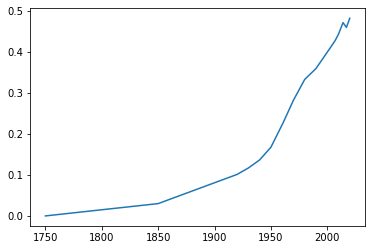

In [7]:
f = interp1d(skeie_ssp245.index, skeie_ssp245, bounds_error=False, fill_value='extrapolate')
years = np.arange(1750,2021)
o3total = f(years)
pl.plot(years, o3total)
print("2014-1750 ozone ERF from Skeie:", o3total[264])
print("2019-1750 ozone ERF from Skeie:", o3total[269])

In [8]:
df = pd.DataFrame(o3total, columns=['o3_erf'], index=np.arange(1750,2021))
df.index.name = 'year'
df.to_csv('../data_output/o3_erf.csv')

## Tuning to emissions for projections

Thornhill et al (2020) contributions to 2014-1850 ozone forcing: 

|species  | best  | unc    |
|---------|-------|--------|
|CH4      | +0.14 | (0.05) |
|NOx      | +0.20 | (0.11) |
|CO + VOC | +0.11 | (0.07) |
|N2O      | +0.03 | (0.02) |
|ODS      | -0.11 | (0.10) |  
|Sum      | +0.37 | (0.18) |

Uncertainties, in brackets, taken to be 5-95%.

Here we will define ODS as the Velders EESC definition.

In [9]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
concentrations = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')

scenario = 'historical'
ch4 = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|CH4')),'1850':'2014'].values.squeeze()
n2o = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|N2O')),'1850':'2014'].values.squeeze()
ods = {}
ods_species = [
    'CCl4',
    'CFC11',
    'CFC113',
    'CFC114',
    'CFC115',
    'CFC12',
    'CH2Cl2',
    'CH3Br',
    'CH3CCl3',
    'CH3Cl',
    'CHCl3',
    'HCFC141b',
    'HCFC142b',
    'HCFC22',
    'Halon1211',
    'Halon1301',
    'Halon2402',
]
for specie in ods_species:
    ods[specie] = concentrations.loc[(concentrations['Scenario']==scenario)&(concentrations['Region']=='World')&(concentrations.Variable.str.endswith('|%s' % specie)),'1850':'2014'].values.squeeze()

co  = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|CO')),'1850':'2014'].interpolate(axis=1).values.squeeze()
nox = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|NOx')),'1850':'2014'].interpolate(axis=1).values.squeeze()
voc = emissions.loc[(emissions['Scenario']==scenario)&(emissions['Region']=='World')&(emissions.Variable.str.endswith('|VOC')),'1850':'2014'].interpolate(axis=1).values.squeeze()

In [10]:
eesc_total = np.zeros((165))
for specie in ods_species:
    eesc_total = eesc_total + eesc(ods[specie], specie)

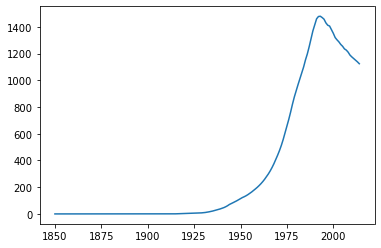

In [11]:
pl.plot(np.arange(1850,2015), eesc_total)

In [12]:
delta_Cch4 = ch4[164] - ch4[0]
delta_Cn2o = n2o[164] - n2o[0]
delta_Cods = eesc_total[164] - eesc_total[0]
delta_Eco  = co[164] - co[0]
delta_Evoc = voc[164] - voc[0]
delta_Enox = nox[164] - nox[0]

In [13]:
# best estimate radiative efficienices from 2014 - 1850

radeff_ch4 = 0.14/delta_Cch4
radeff_n2o = 0.03/delta_Cn2o
radeff_ods = -0.11/delta_Cods
radeff_co  = 0.067/delta_Eco    # stevenson rescaled
radeff_voc = 0.043/delta_Evoc   # stevenson rescaled
radeff_nox = 0.20/delta_Enox

In [14]:
fac_cmip6_skeie = (
    (
    radeff_ch4 * delta_Cch4 +
    radeff_n2o * delta_Cn2o +
    radeff_ods * delta_Cods +
    radeff_co  * delta_Eco +
    radeff_voc * delta_Evoc +
    radeff_nox * delta_Enox 
    ) / (o3total[264]-o3total[100])
)
ts = np.vstack((ch4, n2o, eesc_total, co, voc, nox)).T

In [15]:
ts

array([[ 8.08249029e+02,  2.73021047e+02,  0.00000000e+00,
         4.11462874e+02,  6.67830488e+01,  1.34565768e+01],
       [ 8.08414108e+02,  2.73094050e+02,  0.00000000e+00,
         4.02244815e+02,  6.49500466e+01,  1.31724399e+01],
       [ 8.09163132e+02,  2.73168050e+02,  0.00000000e+00,
         3.97498520e+02,  6.39578999e+01,  1.30018193e+01],
       [ 8.10404058e+02,  2.73264051e+02,  0.00000000e+00,
         4.00338804e+02,  6.44455542e+01,  1.30342532e+01],
       [ 8.11732142e+02,  2.73363050e+02,  0.00000000e+00,
         4.13399132e+02,  6.67946952e+01,  1.34219901e+01],
       [ 8.13332036e+02,  2.73470050e+02,  0.00000000e+00,
         4.08110454e+02,  6.56515640e+01,  1.33736513e+01],
       [ 8.14796122e+02,  2.73578046e+02,  0.00000000e+00,
         4.04854917e+02,  6.50425347e+01,  1.29461467e+01],
       [ 8.16452118e+02,  2.73675049e+02,  0.00000000e+00,
         4.14673192e+02,  6.67277988e+01,  1.36609981e+01],
       [ 8.18355128e+02,  2.73756050e+02,  0.000

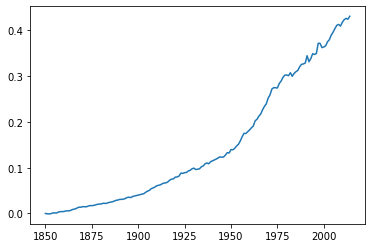

In [16]:
def fit_precursors(x, rch4, rn2o, rods, rco, rvoc, rnox):
    return rch4*x[0] + rn2o*x[1] + rods*x[2] + rco*x[3] + rvoc*x[4] + rnox*x[5]

p, cov = curve_fit(
    fit_precursors, 
    ts.T - ts[0:1, :].T,
    o3total[100:265]-o3total[100],
    bounds=((0.09/delta_Cch4/fac_cmip6_skeie, 0.01/delta_Cn2o/fac_cmip6_skeie, -0.21/delta_Cods/fac_cmip6_skeie, 0.017/delta_Eco/fac_cmip6_skeie, -0.007/delta_Evoc/fac_cmip6_skeie, 0.09/delta_Enox/fac_cmip6_skeie),
            (0.19/delta_Cch4/fac_cmip6_skeie, 0.05/delta_Cn2o/fac_cmip6_skeie, -0.01/delta_Cods/fac_cmip6_skeie, 0.117/delta_Eco/fac_cmip6_skeie, 0.093/delta_Evoc/fac_cmip6_skeie, 0.31/delta_Enox/fac_cmip6_skeie))
)

forcing = (
    p[0] * (ch4 - ch4[0]) +
    p[1] * (n2o - n2o[0]) +
    p[2] * (eesc_total - eesc_total[0]) +
    p[3] * (co  - co[0]) +
    p[4] * (voc  - voc[0]) +
    p[5] * (nox  - nox[0])
)

pl.plot(np.arange(1850,2015), forcing)

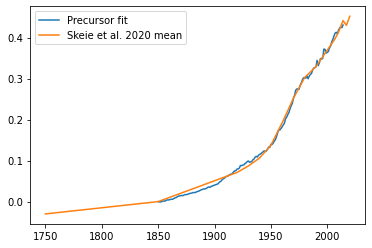

In [17]:
pl.plot(np.arange(1850,2015), forcing, label='Precursor fit')
pl.plot(np.arange(1750,2021), o3total-o3total[100], label='Skeie et al. 2020 mean')
pl.legend()

In [18]:
print(p)  # these coefficients we export to the ERF time series
print(radeff_ch4, radeff_n2o, radeff_ods, radeff_co, radeff_voc, radeff_nox)

[ 2.21453803e-04  1.10494732e-03 -6.01790790e-05  6.04675893e-05
 -5.00668584e-05  1.31468181e-03]
0.00013682270725101268 0.0005558958422888328 -9.787056469289512e-05 0.00012124837094765557 0.0002578827109376753 0.001406631507469693
